# Start here if working in Colab

In [1]:
# Mount Google Drive
%%capture
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive

drive.mount(ROOT);           # we mount the google drive at /content/drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········


In [0]:
# Set working directory
%%capture
%cd /content/drive/My Drive/restoration-mapper

# Start here if working locally

In [3]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np

Using TensorFlow backend.


### Import Data

In [0]:
test_x = np.load('data/test-processed/test_x_l2a_processed.npy')
test_y = np.load('data/test-processed/test_y_l2a_processed.npy')
test_length = np.load('data/test-processed/test_length_l2a_processed.npy')

train_x = np.load('data/train-processed/data_x_l2a_processed.npy')
train_y = np.load('data/train-processed/data_y_l2a_processed.npy')
train_length = np.load('data/train-processed/length_l2a_processed.npy')

In [0]:
# Remove unknown x variable
train_x = np.delete(train_x, 14, -1)
test_x = np.delete(test_x, 14, -1)

### Normalize data

In [0]:
# Normalize data [x_norm = (x - min) / (max - min)]
train_x_min = np.min(train_x, axis = (0,1,2,3))
train_x_range = np.max(train_x, 
                       axis = (0,1,2,3)) - np.min(train_x, axis = (0,1,2,3))

def np_normalize(array, x_min, x_range):
  n = np.prod(array.shape[:-1])
  dim = array.shape
  return (array - np.tile(x_min, 
                          n).reshape(dim)) / np.tile(x_range, n).reshape(dim)

train_x_norm = np_normalize(train_x, train_x_min, train_x_range)
test_x_norm = np_normalize(test_x, train_x_min, train_x_range)

In [7]:
# Check if data is normalized
print("Min value of all variables is 0:", 
      (np.min(train_x_norm[:,:,:,:,:], axis=(0,1,2,3)) == 0).all())
print("Max value of all variables is 1:", 
      (np.max(train_x_norm[:,:,:,:,:], axis=(0,1,2,3)) == 1).all())

Min value of all variables is 0: True
Max value of all variables is 1: True


In [0]:
# Subset data to first time period
train_x_norm = train_x_norm[:, 0, :, :, :]
test_x_norm = test_x_norm[:, 0, :, :, :]

### Define Model

In [0]:
def train(x, y): 
  model = keras.models.Sequential([
    keras.layers.Conv2D(48, (3, 3), strides = 1, padding = "same", activation='relu',
                        input_shape = x.shape[1:],
                        kernel_regularizer=tf.keras.regularizers.l2(0.05),
                        kernel_initializer='glorot_uniform'),
    keras.layers.Conv2D(288, (3, 3), strides = 1, padding = "same", activation='relu',
                        kernel_regularizer=tf.keras.regularizers.l2(0.05),
                        kernel_initializer='glorot_uniform'),
    keras.layers.Conv2D(288, (3, 3), strides = 1, padding = "same", activation='relu',
                        kernel_regularizer=tf.keras.regularizers.l2(0.05),
                        kernel_initializer='glorot_uniform'),
    keras.layers.Conv2D(288, (3, 3), strides = 1, padding = "same", activation='relu',
                        kernel_regularizer=tf.keras.regularizers.l2(0.05),
                        kernel_initializer='glorot_uniform'),
    keras.layers.Conv2D(1, (3, 3), strides = 1, padding = "valid", activation='sigmoid',
                        kernel_regularizer=tf.keras.regularizers.l2(0.05),
                        kernel_initializer='glorot_uniform'),
    keras.layers.Reshape((14,14))
  ])

  loss_fn = keras.losses.BinaryCrossentropy()
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                loss=loss_fn,
                metrics=['accuracy'])
  
  # model fitting
  history = model.fit(x, 
                      y, 
                      batch_size = 355, 
                      validation_split = 0.19, 
                      epochs=500)
  return history.epoch, history.history['accuracy'][-1]

In [17]:
_, _ = train(train_x_norm, train_y)

Train on 3550 samples, validate on 833 samples
Epoch 1/500
3550/3550 [==============================] - 2s 527us/step - loss: 33.5757 - accuracy: 0.7408 - val_loss: 32.1012 - val_accuracy: 0.6568
Epoch 2/500
3550/3550 [==============================] - 2s 440us/step - loss: 30.8754 - accuracy: 0.7409 - val_loss: 29.5501 - val_accuracy: 0.6568
Epoch 3/500
3550/3550 [==============================] - 2s 439us/step - loss: 28.3778 - accuracy: 0.7409 - val_loss: 27.1393 - val_accuracy: 0.6568
Epoch 4/500
3550/3550 [==============================] - 2s 437us/step - loss: 26.0642 - accuracy: 0.7409 - val_loss: 24.9237 - val_accuracy: 0.6568
Epoch 5/500
3550/3550 [==============================] - 2s 438us/step - loss: 23.9279 - accuracy: 0.7409 - val_loss: 22.8873 - val_accuracy: 0.6568
Epoch 6/500
3550/3550 [==============================] - 2s 438us/step - loss: 21.9599 - accuracy: 0.7409 - val_loss: 21.0034 - val_accuracy: 0.6568
Epoch 7/500
3550/3550 [==============================] - 2s

In [0]:
from matplotlib import pyplot as plt

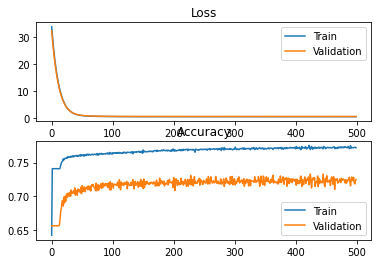

In [23]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['acc'], label='Train')
plt.plot(history.history['val_acc'], label='Validation')
plt.legend()
plt.show()

In [0]:
model.save("models/dpaol_CNN_epoch500.h5")